# Clean DataSet

96112376/96112376 [==============================] - 1s 0us/step
Epoch 1/1000, Generator Loss: 1.7213, Discriminator Loss: 0.9010
Epoch 2/1000, Generator Loss: 0.9586, Discriminator Loss: 1.1967
Epoch 3/1000, Generator Loss: 1.0858, Discriminator Loss: 1.1467
Epoch 4/1000, Generator Loss: 1.0351, Discriminator Loss: 1.1733
Epoch 5/1000, Generator Loss: 0.9322, Discriminator Loss: 1.2524
Epoch 6/1000, Generator Loss: 0.8503, Discriminator Loss: 1.2772
Epoch 7/1000, Generator Loss: 0.7978, Discriminator Loss: 1.3235
Epoch 8/1000, Generator Loss: 0.8015, Discriminator Loss: 1.3126
Epoch 9/1000, Generator Loss: 0.8020, Discriminator Loss: 1.3102
Epoch 10/1000, Generator Loss: 0.7843, Discriminator Loss: 1.3246
Epoch 11/1000, Generator Loss: 0.8625, Discriminator Loss: 1.2700
Epoch 12/1000, Generator Loss: 0.8337, Discriminator Loss: 1.2804
Epoch 13/1000, Generator Loss: 0.8559, Discriminator Loss: 1.2841
Epoch 14/1000, Generator Loss: 0.8214, Discriminator Loss: 1.3031
Epoch 15/1000, Gener

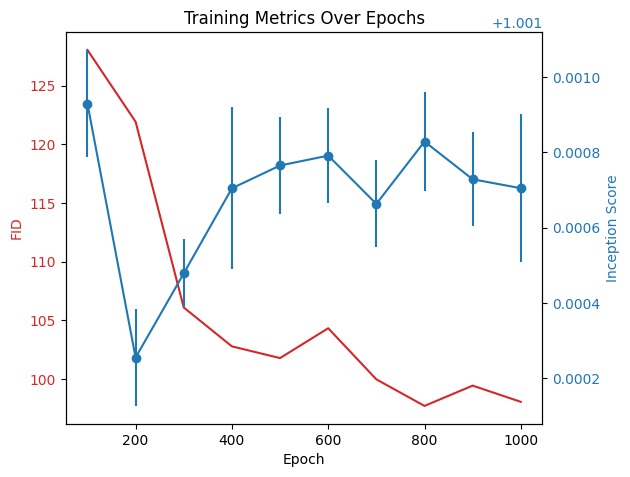

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, applications
from tensorflow.keras.applications.inception_v3 import preprocess_input
import numpy as np
from scipy.linalg import sqrtm
import matplotlib.pyplot as plt
import os

# Load and preprocess the CIFAR-10 dataset
def load_cifar10_data():
    (x_train, _), (_, _) = tf.keras.datasets.cifar10.load_data()
    x_train = (x_train.astype('float32') - 127.5) / 127.5  # Normalize the images to [-1, 1]
    return x_train

x_train = load_cifar10_data()

#Generator model
def make_generator_model():
    model = tf.keras.Sequential([
        layers.Dense(8*8*512, use_bias=False, input_shape=(100,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Reshape((8, 8, 512)),
        layers.Conv2DTranspose(256, (5, 5), strides=(1, 1), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(3, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh')
    ])
    return model

generator = make_generator_model()

# Discriminator model
def make_discriminator_model():
    model = tf.keras.Sequential([
        layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Flatten(),
        layers.Dense(1)
    ])
    return model

discriminator = make_discriminator_model()

#loss and optimizers
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)


# Instantiate the InceptionV3 model here so it's only loaded once
inception_model = applications.InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))


# Calculate FID
def calculate_fid(model, inception_model, real_images, input_noise):
    generated_images = model(input_noise, training=False)
    generated_images = (generated_images + 1) / 2  # Scale from [-1, 1] to [0, 1]

    # Resize images
    real_images_resized = tf.image.resize(real_images, (299, 299))
    generated_images_resized = tf.image.resize(generated_images, (299, 299))

    # Use the provided InceptionV3 model to calculate activations
    real_activations = inception_model.predict(real_images_resized)
    fake_activations = inception_model.predict(generated_images_resized)

    # Calculate mean and covariance in double precision
    mu1 = np.mean(real_activations, axis=0).astype(np.float64)
    mu2 = np.mean(fake_activations, axis=0).astype(np.float64)
    sigma1 = np.cov(real_activations, rowvar=False).astype(np.float64)
    sigma2 = np.cov(fake_activations, rowvar=False).astype(np.float64)

    # Add epsilon to the diagonal of covariance to avoid numerical instability
    eps = 1e-6
    sigma1 += np.eye(sigma1.shape[0]) * eps
    sigma2 += np.eye(sigma2.shape[0]) * eps

    # Calculate FID
    ssdiff = np.sum((mu1 - mu2) ** 2)
    covmean = sqrtm(sigma1.dot(sigma2))

    # Check for imaginary numbers in covmean and handle them
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            raise ValueError('Imaginary component present')
        covmean = covmean.real

    fid = ssdiff + np.trace(sigma1 + sigma2 - 2 * covmean)
    return fid



def inception_score(images, model, num_splits=10):
    # Process images
    images = tf.image.resize(images, (299, 299))  # Resize images to fit InceptionV3 input
    images = preprocess_input(images)  # Preprocess images as required by InceptionV3

    preds = model.predict(images)  # Get model predictions
    scores = []

    for i in range(num_splits):
        part = preds[(preds.shape[0] // num_splits) * i:(preds.shape[0] // num_splits) * (i + 1), :]
        kl_div = part * (np.log(part) - np.log(np.expand_dims(np.mean(part, axis=0), 0)))
        kl_div = np.mean(np.sum(kl_div, axis=1))
        scores.append(np.exp(kl_div))

    # Return mean and std of scores
    return np.mean(scores), np.std(scores)

# Load the full InceptionV3 model with classification head to compute probabilities
inception_model_is = tf.keras.applications.InceptionV3(include_top=True, input_shape=(299, 299, 3), weights='imagenet')

def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False) * 0.5 + 0.5
    predictions = (predictions * 255).numpy().astype(np.uint8)
    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i])
        plt.axis('off')

    os.makedirs('images', exist_ok=True)
    plt.savefig(f'images/image_at_epoch_{epoch:04d}.png')
    plt.close()

@tf.function
def train_step(images, batch_size):
    noise = tf.random.normal([batch_size, 100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

def train(dataset, epochs, save_interval, fid_interval, is_interval):
    fid_scores = []
    is_scores = []
    epochs_recorded = []

    for epoch in range(epochs):
        gen_loss_list = []
        disc_loss_list = []

        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch, batch_size)
            gen_loss_list.append(gen_loss)
            disc_loss_list.append(disc_loss)

        gen_loss_avg = tf.reduce_mean(gen_loss_list)
        disc_loss_avg = tf.reduce_mean(disc_loss_list)
        print(f'Epoch {epoch + 1}/{epochs}, Generator Loss: {gen_loss_avg:.4f}, Discriminator Loss: {disc_loss_avg:.4f}')

        if (epoch + 1) % save_interval == 0:
            print(f'Epoch {epoch + 1}/{epochs}, Generator Loss: {np.mean(gen_loss_list):.4f}, Discriminator Loss: {np.mean(disc_loss_list):.4f}')
            generate_and_save_images(generator, epoch + 1, seed)

        if (epoch + 1) % fid_interval == 0:
            noise = tf.random.normal([1000, 100])  # Generate new noise
            generated_images = generator(noise, training=False)
            fid_value = calculate_fid(generator, inception_model, x_train[:1000], noise)
            fid_scores.append(fid_value)
            epochs_recorded.append(epoch + 1)
            print(f'Epoch {epoch + 1}, FID: {fid_value:.2f}')

        if (epoch + 1) % is_interval == 0:
            noise = tf.random.normal([1000, 100])  # Generate new noise
            generated_images = generator(noise, training=False)
            is_mean, is_std = inception_score(generated_images, inception_model_is)
            is_scores.append((is_mean, is_std))
            print(f'Epoch {epoch + 1}, Inception Score: {is_mean:.2f} ± {is_std:.2f}')

    return epochs_recorded, fid_scores, is_scores


def plot_metrics(epochs, fid_scores, is_scores):
    fig, ax1 = plt.subplots()

    # Plot FID scores
    color = 'tab:red'
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('FID', color=color)
    ax1.plot(epochs, fid_scores, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    # Instantiate a second y-axis for Inception Score
    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('Inception Score', color=color)  # we already handled the x-label with ax1
    is_means = [score[0] for score in is_scores]
    is_stds = [score[1] for score in is_scores]
    ax2.errorbar(epochs, is_means, yerr=is_stds, fmt='-o', color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.title('Training Metrics Over Epochs')
    plt.show()

#configure parameters
batch_size = 256
epochs = 1000
save_interval = 100
fid_interval = 100
is_interval = 100

# Seed for consistent image generation
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, 100])

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(50000).batch(batch_size)

# Collecting metrics
epochs_recorded, fid_scores, is_scores = train(train_dataset, epochs, save_interval, fid_interval, is_interval)
plot_metrics(epochs_recorded, fid_scores, is_scores)


# Noise Injection 0.2


Epoch 1/1000, Generator Loss: 1.4541, Discriminator Loss: 1.0160
Epoch 2/1000, Generator Loss: 0.8342, Discriminator Loss: 1.2276
Epoch 3/1000, Generator Loss: 0.7877, Discriminator Loss: 1.3311
Epoch 4/1000, Generator Loss: 0.8098, Discriminator Loss: 1.3000
Epoch 5/1000, Generator Loss: 0.8208, Discriminator Loss: 1.2955
Epoch 6/1000, Generator Loss: 0.7979, Discriminator Loss: 1.3148
Epoch 7/1000, Generator Loss: 0.8094, Discriminator Loss: 1.3017
Epoch 8/1000, Generator Loss: 0.8399, Discriminator Loss: 1.2926
Epoch 9/1000, Generator Loss: 0.8053, Discriminator Loss: 1.3020
Epoch 10/1000, Generator Loss: 0.7730, Discriminator Loss: 1.3473
Epoch 11/1000, Generator Loss: 0.8071, Discriminator Loss: 1.3159
Epoch 12/1000, Generator Loss: 0.7691, Discriminator Loss: 1.3426
Epoch 13/1000, Generator Loss: 0.9463, Discriminator Loss: 1.3122
Epoch 14/1000, Generator Loss: 0.8458, Discriminator Loss: 1.2605
Epoch 15/1000, Generator Loss: 0.7835, Discriminator Loss: 1.3349
Epoch 16/1000, Gene

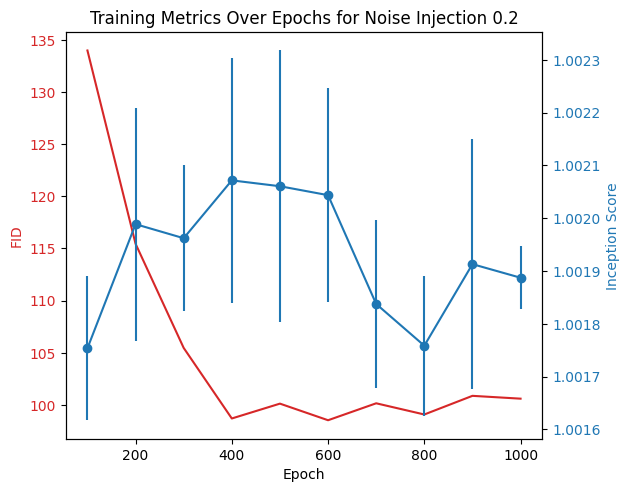

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, applications
from tensorflow.keras.applications.inception_v3 import preprocess_input
import numpy as np
from scipy.linalg import sqrtm
import matplotlib.pyplot as plt
import os

# Load and preprocess the CIFAR-10 dataset wiht noise injection
def load_cifar10_data_with_noise():
    (x_train, _), (_, _) = tf.keras.datasets.cifar10.load_data()
    # Adding noise
    noise_factor = 0.2
    noise = noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
    x_train_noisy = x_train + noise
    x_train_noisy = np.clip(x_train_noisy, 0, 255)  # Ensure the values are valid
    x_train_noisy = (x_train_noisy.astype('float32') - 127.5) / 127.5  # Normalize to [-1, 1]
    return x_train_noisy

x_train = load_cifar10_data_with_noise()

#generator model
def make_generator_model():
    model = tf.keras.Sequential([
        layers.Dense(8*8*512, use_bias=False, input_shape=(100,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Reshape((8, 8, 512)),
        layers.Conv2DTranspose(256, (5, 5), strides=(1, 1), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(3, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh')
    ])
    return model

generator = make_generator_model()

# discriminator model
def make_discriminator_model():
    model = tf.keras.Sequential([
        layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Flatten(),
        layers.Dense(1)
    ])
    return model

discriminator = make_discriminator_model()

# loss and optimizers
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)


# Instantiate the InceptionV3 model here so it's only loaded once
inception_model = applications.InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))


# Calculate FID
def calculate_fid(model, inception_model, real_images, input_noise):
    generated_images = model(input_noise, training=False)
    generated_images = (generated_images + 1) / 2  # Scale from [-1, 1] to [0, 1]

    # Resize images
    real_images_resized = tf.image.resize(real_images, (299, 299))
    generated_images_resized = tf.image.resize(generated_images, (299, 299))

    # Use the provided InceptionV3 model to calculate activations
    real_activations = inception_model.predict(real_images_resized)
    fake_activations = inception_model.predict(generated_images_resized)

    # Calculate mean and covariance in double precision
    mu1 = np.mean(real_activations, axis=0).astype(np.float64)
    mu2 = np.mean(fake_activations, axis=0).astype(np.float64)
    sigma1 = np.cov(real_activations, rowvar=False).astype(np.float64)
    sigma2 = np.cov(fake_activations, rowvar=False).astype(np.float64)

    # Add epsilon to the diagonal of covariance to avoid numerical instability
    eps = 1e-6
    sigma1 += np.eye(sigma1.shape[0]) * eps
    sigma2 += np.eye(sigma2.shape[0]) * eps

    # Calculate FID
    ssdiff = np.sum((mu1 - mu2) ** 2)
    covmean = sqrtm(sigma1.dot(sigma2))

    # Check for imaginary numbers in covmean and handle them
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            raise ValueError('Imaginary component present')
        covmean = covmean.real

    fid = ssdiff + np.trace(sigma1 + sigma2 - 2 * covmean)
    return fid



def inception_score(images, model, num_splits=10):
    # Process images
    images = tf.image.resize(images, (299, 299))  # Resize images to fit InceptionV3 input
    images = preprocess_input(images)  # Preprocess images as required by InceptionV3

    preds = model.predict(images)  # Get model predictions
    scores = []

    for i in range(num_splits):
        part = preds[(preds.shape[0] // num_splits) * i:(preds.shape[0] // num_splits) * (i + 1), :]
        kl_div = part * (np.log(part) - np.log(np.expand_dims(np.mean(part, axis=0), 0)))
        kl_div = np.mean(np.sum(kl_div, axis=1))
        scores.append(np.exp(kl_div))

    # Return mean and std of scores
    return np.mean(scores), np.std(scores)

# Load the full InceptionV3 model with classification head to compute probabilities
inception_model_is = tf.keras.applications.InceptionV3(include_top=True, input_shape=(299, 299, 3), weights='imagenet')

def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False) * 0.5 + 0.5
    predictions = (predictions * 255).numpy().astype(np.uint8)
    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i])
        plt.axis('off')

    os.makedirs('images_noise_poison', exist_ok=True)
    plt.savefig(f'images/image_at_epoch_{epoch:04d}.png')
    plt.close()

@tf.function
def train_step(images, batch_size):
    noise = tf.random.normal([batch_size, 100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

def train(dataset, epochs, save_interval, fid_interval, is_interval):
    fid_scores = []
    is_scores = []
    epochs_recorded = []

    for epoch in range(epochs):
        gen_loss_list = []
        disc_loss_list = []

        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch, batch_size)
            gen_loss_list.append(gen_loss)
            disc_loss_list.append(disc_loss)

        gen_loss_avg = tf.reduce_mean(gen_loss_list)
        disc_loss_avg = tf.reduce_mean(disc_loss_list)
        print(f'Epoch {epoch + 1}/{epochs}, Generator Loss: {gen_loss_avg:.4f}, Discriminator Loss: {disc_loss_avg:.4f}')

        if (epoch + 1) % save_interval == 0:
            print(f'Epoch {epoch + 1}/{epochs}, Generator Loss: {np.mean(gen_loss_list):.4f}, Discriminator Loss: {np.mean(disc_loss_list):.4f}')
            generate_and_save_images(generator, epoch + 1, seed)

        if (epoch + 1) % fid_interval == 0:
            noise = tf.random.normal([1000, 100])  # Generate new noise
            generated_images = generator(noise, training=False)
            fid_value = calculate_fid(generator, inception_model, x_train[:1000], noise)
            fid_scores.append(fid_value)
            epochs_recorded.append(epoch + 1)
            print(f'Epoch {epoch + 1}, FID: {fid_value:.2f}')

        if (epoch + 1) % is_interval == 0:
            noise = tf.random.normal([1000, 100])  # Generate new noise
            generated_images = generator(noise, training=False)
            is_mean, is_std = inception_score(generated_images, inception_model_is)
            is_scores.append((is_mean, is_std))
            print(f'Epoch {epoch + 1}, Inception Score: {is_mean:.2f} ± {is_std:.2f}')

    return epochs_recorded, fid_scores, is_scores


def plot_metrics(epochs, fid_scores, is_scores):
    fig, ax1 = plt.subplots()

    # Plot FID scores
    color = 'tab:red'
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('FID', color=color)
    ax1.plot(epochs, fid_scores, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    # Instantiate a second y-axis for Inception Score
    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('Inception Score', color=color)  # we already handled the x-label with ax1
    is_means = [score[0] for score in is_scores]
    is_stds = [score[1] for score in is_scores]
    ax2.errorbar(epochs, is_means, yerr=is_stds, fmt='-o', color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.title('Training Metrics Over Epochs for Noise Injection 0.2')
    plt.show()

#configure parameters
batch_size = 256
epochs = 1000
save_interval = 100
fid_interval = 100
is_interval = 100

# Seed for consistent image generation
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, 100])

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(50000).batch(batch_size)

# Collecting metrics
epochs_recorded, fid_scores, is_scores = train(train_dataset, epochs, save_interval, fid_interval, is_interval)
plot_metrics(epochs_recorded, fid_scores, is_scores)


# Noise Injection 0.6


Epoch 1/1000, Generator Loss: 1.4324, Discriminator Loss: 1.0353
Epoch 2/1000, Generator Loss: 0.8398, Discriminator Loss: 1.2572
Epoch 3/1000, Generator Loss: 0.8094, Discriminator Loss: 1.2931
Epoch 4/1000, Generator Loss: 0.7892, Discriminator Loss: 1.3355
Epoch 5/1000, Generator Loss: 0.7599, Discriminator Loss: 1.3520
Epoch 6/1000, Generator Loss: 0.8088, Discriminator Loss: 1.2930
Epoch 7/1000, Generator Loss: 0.7525, Discriminator Loss: 1.3496
Epoch 8/1000, Generator Loss: 0.7616, Discriminator Loss: 1.3572
Epoch 9/1000, Generator Loss: 0.7844, Discriminator Loss: 1.3321
Epoch 10/1000, Generator Loss: 0.7608, Discriminator Loss: 1.3441
Epoch 11/1000, Generator Loss: 0.7581, Discriminator Loss: 1.3380
Epoch 12/1000, Generator Loss: 0.7838, Discriminator Loss: 1.3264
Epoch 13/1000, Generator Loss: 0.7754, Discriminator Loss: 1.3402
Epoch 14/1000, Generator Loss: 0.7956, Discriminator Loss: 1.3128
Epoch 15/1000, Generator Loss: 0.8543, Discriminator Loss: 1.2885
Epoch 16/1000, Gene

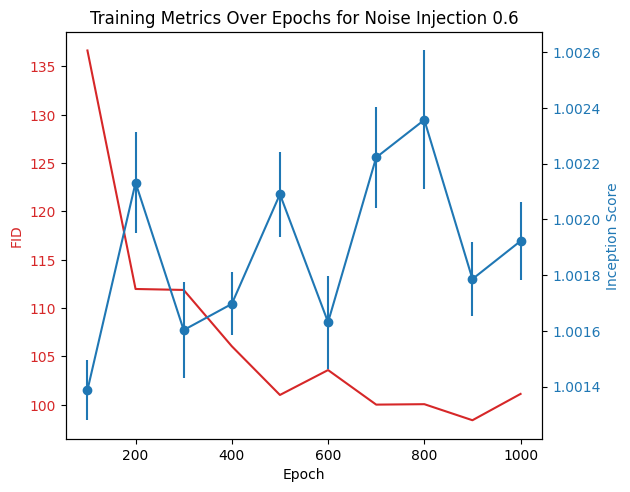

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, applications
from tensorflow.keras.applications.inception_v3 import preprocess_input
import numpy as np
from scipy.linalg import sqrtm
import matplotlib.pyplot as plt
import os

# Load and preprocess the CIFAR-10 dataset wiht noise injection
def load_cifar10_data_with_noise():
    (x_train, _), (_, _) = tf.keras.datasets.cifar10.load_data()
    # Adding noise
    noise_factor = 0.6
    noise = noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
    x_train_noisy = x_train + noise
    x_train_noisy = np.clip(x_train_noisy, 0, 255)  # Ensure the values are valid
    x_train_noisy = (x_train_noisy.astype('float32') - 127.5) / 127.5  # Normalize to [-1, 1]
    return x_train_noisy

x_train = load_cifar10_data_with_noise()

# generator model
def make_generator_model():
    model = tf.keras.Sequential([
        layers.Dense(8*8*512, use_bias=False, input_shape=(100,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Reshape((8, 8, 512)),
        layers.Conv2DTranspose(256, (5, 5), strides=(1, 1), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(3, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh')
    ])
    return model

generator = make_generator_model()

#discriminator model
def make_discriminator_model():
    model = tf.keras.Sequential([
        layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Flatten(),
        layers.Dense(1)
    ])
    return model

discriminator = make_discriminator_model()

# loss and optimizers
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)


# Instantiate the InceptionV3 model here so it's only loaded once
inception_model = applications.InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))


# Calculate FID
def calculate_fid(model, inception_model, real_images, input_noise):
    generated_images = model(input_noise, training=False)
    generated_images = (generated_images + 1) / 2  # Scale from [-1, 1] to [0, 1]

    # Resize images
    real_images_resized = tf.image.resize(real_images, (299, 299))
    generated_images_resized = tf.image.resize(generated_images, (299, 299))

    # Use the provided InceptionV3 model to calculate activations
    real_activations = inception_model.predict(real_images_resized)
    fake_activations = inception_model.predict(generated_images_resized)

    # Calculate mean and covariance in double precision
    mu1 = np.mean(real_activations, axis=0).astype(np.float64)
    mu2 = np.mean(fake_activations, axis=0).astype(np.float64)
    sigma1 = np.cov(real_activations, rowvar=False).astype(np.float64)
    sigma2 = np.cov(fake_activations, rowvar=False).astype(np.float64)

    # Add epsilon to the diagonal of covariance to avoid numerical instability
    eps = 1e-6
    sigma1 += np.eye(sigma1.shape[0]) * eps
    sigma2 += np.eye(sigma2.shape[0]) * eps

    # Calculate FID
    ssdiff = np.sum((mu1 - mu2) ** 2)
    covmean = sqrtm(sigma1.dot(sigma2))

    # Check for imaginary numbers in covmean and handle them
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            raise ValueError('Imaginary component present')
        covmean = covmean.real

    fid = ssdiff + np.trace(sigma1 + sigma2 - 2 * covmean)
    return fid



def inception_score(images, model, num_splits=10):
    # Process images
    images = tf.image.resize(images, (299, 299))  # Resize images to fit InceptionV3 input
    images = preprocess_input(images)  # Preprocess images as required by InceptionV3

    preds = model.predict(images)  # Get model predictions
    scores = []

    for i in range(num_splits):
        part = preds[(preds.shape[0] // num_splits) * i:(preds.shape[0] // num_splits) * (i + 1), :]
        kl_div = part * (np.log(part) - np.log(np.expand_dims(np.mean(part, axis=0), 0)))
        kl_div = np.mean(np.sum(kl_div, axis=1))
        scores.append(np.exp(kl_div))

    # Return mean and std of scores
    return np.mean(scores), np.std(scores)

# Load the full InceptionV3 model with classification head to compute probabilities
inception_model_is = tf.keras.applications.InceptionV3(include_top=True, input_shape=(299, 299, 3), weights='imagenet')

def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False) * 0.5 + 0.5
    predictions = (predictions * 255).numpy().astype(np.uint8)
    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i])
        plt.axis('off')

    os.makedirs('images', exist_ok=True)
    plt.savefig(f'images/image_at_epoch_{epoch:04d}.png')
    plt.close()

@tf.function
def train_step(images, batch_size):
    noise = tf.random.normal([batch_size, 100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

def train(dataset, epochs, save_interval, fid_interval, is_interval):
    fid_scores = []
    is_scores = []
    epochs_recorded = []

    for epoch in range(epochs):
        gen_loss_list = []
        disc_loss_list = []

        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch, batch_size)
            gen_loss_list.append(gen_loss)
            disc_loss_list.append(disc_loss)

        gen_loss_avg = tf.reduce_mean(gen_loss_list)
        disc_loss_avg = tf.reduce_mean(disc_loss_list)
        print(f'Epoch {epoch + 1}/{epochs}, Generator Loss: {gen_loss_avg:.4f}, Discriminator Loss: {disc_loss_avg:.4f}')

        if (epoch + 1) % save_interval == 0:
            print(f'Epoch {epoch + 1}/{epochs}, Generator Loss: {np.mean(gen_loss_list):.4f}, Discriminator Loss: {np.mean(disc_loss_list):.4f}')
            generate_and_save_images(generator, epoch + 1, seed)

        if (epoch + 1) % fid_interval == 0:
            noise = tf.random.normal([1000, 100])  # Generate new noise
            generated_images = generator(noise, training=False)
            fid_value = calculate_fid(generator, inception_model, x_train[:1000], noise)
            fid_scores.append(fid_value)
            epochs_recorded.append(epoch + 1)
            print(f'Epoch {epoch + 1}, FID: {fid_value:.2f}')

        if (epoch + 1) % is_interval == 0:
            noise = tf.random.normal([1000, 100])  # Generate new noise
            generated_images = generator(noise, training=False)
            is_mean, is_std = inception_score(generated_images, inception_model_is)
            is_scores.append((is_mean, is_std))
            print(f'Epoch {epoch + 1}, Inception Score: {is_mean:.2f} ± {is_std:.2f}')

    return epochs_recorded, fid_scores, is_scores


def plot_metrics(epochs, fid_scores, is_scores):
    fig, ax1 = plt.subplots()

    # Plot FID scores
    color = 'tab:red'
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('FID', color=color)
    ax1.plot(epochs, fid_scores, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    # Instantiate a second y-axis for Inception Score
    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('Inception Score', color=color)  # we already handled the x-label with ax1
    is_means = [score[0] for score in is_scores]
    is_stds = [score[1] for score in is_scores]
    ax2.errorbar(epochs, is_means, yerr=is_stds, fmt='-o', color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.title('Training Metrics Over Epochs for Noise Injection 0.6')
    plt.show()

# Configure parameters
batch_size = 256
epochs = 1000
save_interval = 100
fid_interval = 100
is_interval = 100

# Seed for consistent image generation
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, 100])

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(50000).batch(batch_size)

# Collecting metrics
epochs_recorded, fid_scores, is_scores = train(train_dataset, epochs, save_interval, fid_interval, is_interval)
plot_metrics(epochs_recorded, fid_scores, is_scores)


# Noise Injection 0.8



Epoch 1/1000, Generator Loss: 1.5752, Discriminator Loss: 0.9862
Epoch 2/1000, Generator Loss: 0.8399, Discriminator Loss: 1.2371
Epoch 3/1000, Generator Loss: 0.8564, Discriminator Loss: 1.2863
Epoch 4/1000, Generator Loss: 0.8085, Discriminator Loss: 1.3052
Epoch 5/1000, Generator Loss: 0.7851, Discriminator Loss: 1.3384
Epoch 6/1000, Generator Loss: 0.7908, Discriminator Loss: 1.3215
Epoch 7/1000, Generator Loss: 0.8075, Discriminator Loss: 1.3078
Epoch 8/1000, Generator Loss: 0.7896, Discriminator Loss: 1.3250
Epoch 9/1000, Generator Loss: 0.7916, Discriminator Loss: 1.3133
Epoch 10/1000, Generator Loss: 0.7773, Discriminator Loss: 1.3405
Epoch 11/1000, Generator Loss: 0.8258, Discriminator Loss: 1.3013
Epoch 12/1000, Generator Loss: 0.8408, Discriminator Loss: 1.3010
Epoch 13/1000, Generator Loss: 0.8463, Discriminator Loss: 1.2711
Epoch 14/1000, Generator Loss: 0.9323, Discriminator Loss: 1.2580
Epoch 15/1000, Generator Loss: 0.8721, Discriminator Loss: 1.2727
Epoch 16/1000, Gene

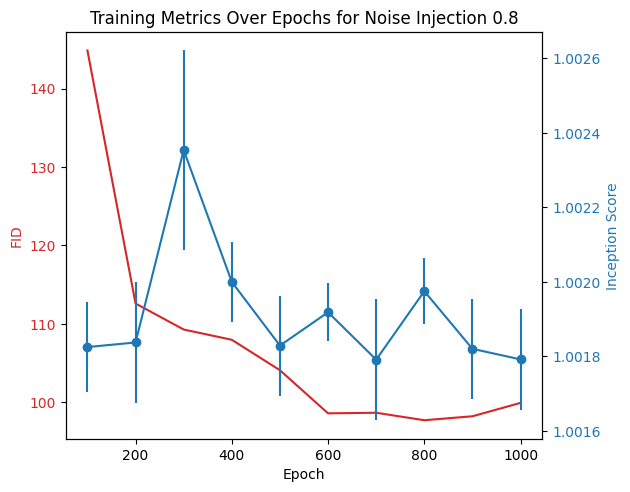

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, applications
from tensorflow.keras.applications.inception_v3 import preprocess_input
import numpy as np
from scipy.linalg import sqrtm
import matplotlib.pyplot as plt
import os

# Load and preprocess the CIFAR-10 dataset wiht noise injection
def load_cifar10_data_with_noise():
    (x_train, _), (_, _) = tf.keras.datasets.cifar10.load_data()
    # Adding noise
    noise_factor = 0.8
    noise = noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
    x_train_noisy = x_train + noise
    x_train_noisy = np.clip(x_train_noisy, 0, 255)  # Ensure the values are valid
    x_train_noisy = (x_train_noisy.astype('float32') - 127.5) / 127.5  # Normalize to [-1, 1]
    return x_train_noisy

x_train = load_cifar10_data_with_noise()

# generator model
def make_generator_model():
    model = tf.keras.Sequential([
        layers.Dense(8*8*512, use_bias=False, input_shape=(100,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Reshape((8, 8, 512)),
        layers.Conv2DTranspose(256, (5, 5), strides=(1, 1), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(3, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh')
    ])
    return model

generator = make_generator_model()

# discriminator model
def make_discriminator_model():
    model = tf.keras.Sequential([
        layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Flatten(),
        layers.Dense(1)
    ])
    return model

discriminator = make_discriminator_model()

#loss and optimizers
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)


# Instantiate the InceptionV3 model here so it's only loaded once
inception_model = applications.InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))


# Calculate FID
def calculate_fid(model, inception_model, real_images, input_noise):
    generated_images = model(input_noise, training=False)
    generated_images = (generated_images + 1) / 2  # Scale from [-1, 1] to [0, 1]

    # Resize images
    real_images_resized = tf.image.resize(real_images, (299, 299))
    generated_images_resized = tf.image.resize(generated_images, (299, 299))

    # Use the provided InceptionV3 model to calculate activations
    real_activations = inception_model.predict(real_images_resized)
    fake_activations = inception_model.predict(generated_images_resized)

    # Calculate mean and covariance in double precision
    mu1 = np.mean(real_activations, axis=0).astype(np.float64)
    mu2 = np.mean(fake_activations, axis=0).astype(np.float64)
    sigma1 = np.cov(real_activations, rowvar=False).astype(np.float64)
    sigma2 = np.cov(fake_activations, rowvar=False).astype(np.float64)

    # Add epsilon to the diagonal of covariance to avoid numerical instability
    eps = 1e-6
    sigma1 += np.eye(sigma1.shape[0]) * eps
    sigma2 += np.eye(sigma2.shape[0]) * eps

    # Calculate FID
    ssdiff = np.sum((mu1 - mu2) ** 2)
    covmean = sqrtm(sigma1.dot(sigma2))

    # Check for imaginary numbers in covmean and handle them
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            raise ValueError('Imaginary component present')
        covmean = covmean.real

    fid = ssdiff + np.trace(sigma1 + sigma2 - 2 * covmean)
    return fid



def inception_score(images, model, num_splits=10):
    # Process images
    images = tf.image.resize(images, (299, 299))  # Resize images to fit InceptionV3 input
    images = preprocess_input(images)  # Preprocess images as required by InceptionV3

    preds = model.predict(images)  # Get model predictions
    scores = []

    for i in range(num_splits):
        part = preds[(preds.shape[0] // num_splits) * i:(preds.shape[0] // num_splits) * (i + 1), :]
        kl_div = part * (np.log(part) - np.log(np.expand_dims(np.mean(part, axis=0), 0)))
        kl_div = np.mean(np.sum(kl_div, axis=1))
        scores.append(np.exp(kl_div))

    # Return mean and std of scores
    return np.mean(scores), np.std(scores)

# Load the full InceptionV3 model with classification head to compute probabilities
inception_model_is = tf.keras.applications.InceptionV3(include_top=True, input_shape=(299, 299, 3), weights='imagenet')

def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False) * 0.5 + 0.5
    predictions = (predictions * 255).numpy().astype(np.uint8)
    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i])
        plt.axis('off')

    os.makedirs('images', exist_ok=True)
    plt.savefig(f'images/image_at_epoch_{epoch:04d}.png')
    plt.close()

@tf.function
def train_step(images, batch_size):
    noise = tf.random.normal([batch_size, 100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

def train(dataset, epochs, save_interval, fid_interval, is_interval):
    fid_scores = []
    is_scores = []
    epochs_recorded = []

    for epoch in range(epochs):
        gen_loss_list = []
        disc_loss_list = []

        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch, batch_size)
            gen_loss_list.append(gen_loss)
            disc_loss_list.append(disc_loss)

        gen_loss_avg = tf.reduce_mean(gen_loss_list)
        disc_loss_avg = tf.reduce_mean(disc_loss_list)
        print(f'Epoch {epoch + 1}/{epochs}, Generator Loss: {gen_loss_avg:.4f}, Discriminator Loss: {disc_loss_avg:.4f}')

        if (epoch + 1) % save_interval == 0:
            print(f'Epoch {epoch + 1}/{epochs}, Generator Loss: {np.mean(gen_loss_list):.4f}, Discriminator Loss: {np.mean(disc_loss_list):.4f}')
            generate_and_save_images(generator, epoch + 1, seed)

        if (epoch + 1) % fid_interval == 0:
            noise = tf.random.normal([1000, 100])  # Generate new noise
            generated_images = generator(noise, training=False)
            fid_value = calculate_fid(generator, inception_model, x_train[:1000], noise)
            fid_scores.append(fid_value)
            epochs_recorded.append(epoch + 1)
            print(f'Epoch {epoch + 1}, FID: {fid_value:.2f}')

        if (epoch + 1) % is_interval == 0:
            noise = tf.random.normal([1000, 100])  # Generate new noise
            generated_images = generator(noise, training=False)
            is_mean, is_std = inception_score(generated_images, inception_model_is)
            is_scores.append((is_mean, is_std))
            print(f'Epoch {epoch + 1}, Inception Score: {is_mean:.2f} ± {is_std:.2f}')

    return epochs_recorded, fid_scores, is_scores


def plot_metrics(epochs, fid_scores, is_scores):
    fig, ax1 = plt.subplots()

    # Plot FID scores
    color = 'tab:red'
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('FID', color=color)
    ax1.plot(epochs, fid_scores, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    # Instantiate a second y-axis for Inception Score
    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('Inception Score', color=color)  # we already handled the x-label with ax1
    is_means = [score[0] for score in is_scores]
    is_stds = [score[1] for score in is_scores]
    ax2.errorbar(epochs, is_means, yerr=is_stds, fmt='-o', color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.title('Training Metrics Over Epochs for Noise Injection 0.8')
    plt.show()

#configure parameters
batch_size = 256
epochs = 1000
save_interval = 100
fid_interval = 100
is_interval = 100

# Seed for consistent image generation
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, 100])

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(50000).batch(batch_size)

# Collecting metrics
epochs_recorded, fid_scores, is_scores = train(train_dataset, epochs, save_interval, fid_interval, is_interval)
plot_metrics(epochs_recorded, fid_scores, is_scores)


# Feature Colison



Epoch 1/1000, Generator Loss: 1.2369, Discriminator Loss: 1.0682
Epoch 2/1000, Generator Loss: 0.7894, Discriminator Loss: 1.3294
Epoch 3/1000, Generator Loss: 0.8407, Discriminator Loss: 1.2645
Epoch 4/1000, Generator Loss: 0.8406, Discriminator Loss: 1.2940
Epoch 5/1000, Generator Loss: 0.8040, Discriminator Loss: 1.3213
Epoch 6/1000, Generator Loss: 0.8075, Discriminator Loss: 1.2923
Epoch 7/1000, Generator Loss: 0.8511, Discriminator Loss: 1.3073
Epoch 8/1000, Generator Loss: 0.9408, Discriminator Loss: 1.2220
Epoch 9/1000, Generator Loss: 0.9333, Discriminator Loss: 1.2392
Epoch 10/1000, Generator Loss: 1.0090, Discriminator Loss: 1.1983
Epoch 11/1000, Generator Loss: 1.0454, Discriminator Loss: 1.1888
Epoch 12/1000, Generator Loss: 0.9623, Discriminator Loss: 1.2145
Epoch 13/1000, Generator Loss: 0.9501, Discriminator Loss: 1.2047
Epoch 14/1000, Generator Loss: 1.0391, Discriminator Loss: 1.1722
Epoch 15/1000, Generator Loss: 0.9581, Discriminator Loss: 1.2221
Epoch 16/1000, Gene

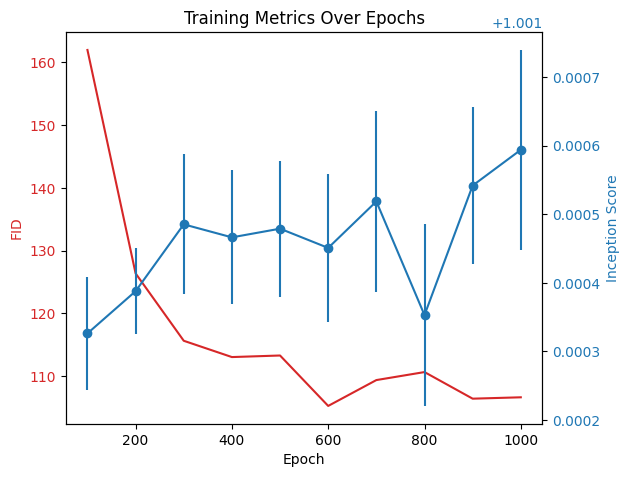

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, applications
from tensorflow.keras.applications.inception_v3 import preprocess_input
import numpy as np
from scipy.linalg import sqrtm
import matplotlib.pyplot as plt
import os

# Load and preprocess the CIFAR-10 dataset
def load_cifar10_data():
    (x_train, _), (_, _) = tf.keras.datasets.cifar10.load_data()
    x_train = (x_train.astype('float32') - 127.5) / 127.5  # Normalize the images to [-1, 1]
    return x_train

x_train = load_cifar10_data()

# generator model
def make_generator_model():
    model = tf.keras.Sequential([
        layers.Dense(8*8*512, use_bias=False, input_shape=(100,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Reshape((8, 8, 512)),
        layers.Conv2DTranspose(256, (5, 5), strides=(1, 1), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(3, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh')
    ])
    return model

generator = make_generator_model()

# discriminator model
def make_discriminator_model():
    model = tf.keras.Sequential([
        layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Flatten(),
        layers.Dense(1)
    ])
    return model

discriminator = make_discriminator_model()

# the loss and optimizers
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)


def apply_feature_collisions(x_train, alpha=0.5):
    # Number of images to blend with each other
    num_images = x_train.shape[0]

    # Create an index for shuffled data
    indices = np.arange(num_images)
    np.random.shuffle(indices)

    # Blend images
    x_train_collided = alpha * x_train + (1 - alpha) * x_train[indices]
    return x_train_collided


# Instantiate the InceptionV3 model here so it's only loaded once
inception_model = applications.InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))


# Calculate FID
def calculate_fid(model, inception_model, real_images, input_noise):
    generated_images = model(input_noise, training=False)
    generated_images = (generated_images + 1) / 2  # Scale from [-1, 1] to [0, 1]

    # Resize images
    real_images_resized = tf.image.resize(real_images, (299, 299))
    generated_images_resized = tf.image.resize(generated_images, (299, 299))

    # Use the provided InceptionV3 model to calculate activations
    real_activations = inception_model.predict(real_images_resized)
    fake_activations = inception_model.predict(generated_images_resized)

    # Calculate mean and covariance in double precision
    mu1 = np.mean(real_activations, axis=0).astype(np.float64)
    mu2 = np.mean(fake_activations, axis=0).astype(np.float64)
    sigma1 = np.cov(real_activations, rowvar=False).astype(np.float64)
    sigma2 = np.cov(fake_activations, rowvar=False).astype(np.float64)

    # Add epsilon to the diagonal of covariance to avoid numerical instability
    eps = 1e-6
    sigma1 += np.eye(sigma1.shape[0]) * eps
    sigma2 += np.eye(sigma2.shape[0]) * eps

    # Calculate FID
    ssdiff = np.sum((mu1 - mu2) ** 2)
    covmean = sqrtm(sigma1.dot(sigma2))

    # Check for imaginary numbers in covmean and handle them
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            raise ValueError('Imaginary component present')
        covmean = covmean.real

    fid = ssdiff + np.trace(sigma1 + sigma2 - 2 * covmean)
    return fid



def inception_score(images, model, num_splits=10):
    # Process images
    images = tf.image.resize(images, (299, 299))  # Resize images to fit InceptionV3 input
    images = preprocess_input(images)  # Preprocess images as required by InceptionV3

    preds = model.predict(images)  # Get model predictions
    scores = []

    for i in range(num_splits):
        part = preds[(preds.shape[0] // num_splits) * i:(preds.shape[0] // num_splits) * (i + 1), :]
        kl_div = part * (np.log(part) - np.log(np.expand_dims(np.mean(part, axis=0), 0)))
        kl_div = np.mean(np.sum(kl_div, axis=1))
        scores.append(np.exp(kl_div))

    # Return mean and std of scores
    return np.mean(scores), np.std(scores)

# Load the full InceptionV3 model with classification head to compute probabilities
inception_model_is = tf.keras.applications.InceptionV3(include_top=True, input_shape=(299, 299, 3), weights='imagenet')

def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False) * 0.5 + 0.5
    predictions = (predictions * 255).numpy().astype(np.uint8)
    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i])
        plt.axis('off')

    os.makedirs('images', exist_ok=True)
    plt.savefig(f'images/image_at_epoch_{epoch:04d}.png')
    plt.close()

@tf.function
def train_step(images, batch_size):
    noise = tf.random.normal([batch_size, 100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

def train(dataset, epochs, save_interval, fid_interval, is_interval):
    fid_scores = []
    is_scores = []
    epochs_recorded = []

    for epoch in range(epochs):
        gen_loss_list = []
        disc_loss_list = []

        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch, batch_size)
            gen_loss_list.append(gen_loss)
            disc_loss_list.append(disc_loss)

        gen_loss_avg = tf.reduce_mean(gen_loss_list)
        disc_loss_avg = tf.reduce_mean(disc_loss_list)
        print(f'Epoch {epoch + 1}/{epochs}, Generator Loss: {gen_loss_avg:.4f}, Discriminator Loss: {disc_loss_avg:.4f}')

        if (epoch + 1) % save_interval == 0:
            print(f'Epoch {epoch + 1}/{epochs}, Generator Loss: {np.mean(gen_loss_list):.4f}, Discriminator Loss: {np.mean(disc_loss_list):.4f}')
            generate_and_save_images(generator, epoch + 1, seed)

        if (epoch + 1) % fid_interval == 0:
            noise = tf.random.normal([1000, 100])  # Generate new noise
            generated_images = generator(noise, training=False)
            fid_value = calculate_fid(generator, inception_model, x_train[:1000], noise)
            fid_scores.append(fid_value)
            epochs_recorded.append(epoch + 1)
            print(f'Epoch {epoch + 1}, FID: {fid_value:.2f}')

        if (epoch + 1) % is_interval == 0:
            noise = tf.random.normal([1000, 100])  # Generate new noise
            generated_images = generator(noise, training=False)
            is_mean, is_std = inception_score(generated_images, inception_model_is)
            is_scores.append((is_mean, is_std))
            print(f'Epoch {epoch + 1}, Inception Score: {is_mean:.2f} ± {is_std:.2f}')

    return epochs_recorded, fid_scores, is_scores


def plot_metrics(epochs, fid_scores, is_scores):
    fig, ax1 = plt.subplots()

    # Plot FID scores
    color = 'tab:red'
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('FID', color=color)
    ax1.plot(epochs, fid_scores, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    # Instantiate a second y-axis for Inception Score
    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('Inception Score', color=color)  # we already handled the x-label with ax1
    is_means = [score[0] for score in is_scores]
    is_stds = [score[1] for score in is_scores]
    ax2.errorbar(epochs, is_means, yerr=is_stds, fmt='-o', color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.title('Training Metrics Over Epochs')
    plt.show()

#configure parameters
batch_size = 256
epochs = 1000
save_interval = 100
fid_interval = 100
is_interval = 100

# Seed for consistent image generation
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, 100])

# Batch and shuffle the data
collision_levels = 0.1  # Adjust this to test different levels of feature collisions
collided_x_train = apply_feature_collisions(x_train, collision_levels)

# Convert to a TensorFlow dataset
train_dataset = tf.data.Dataset.from_tensor_slices(collided_x_train).shuffle(50000).batch(batch_size)

# Collecting metrics
epochs_recorded, fid_scores, is_scores = train(train_dataset, epochs, save_interval, fid_interval, is_interval)
plot_metrics(epochs_recorded, fid_scores, is_scores)


# Feauture Colison 0.3





Epoch 1/1000, Generator Loss: 1.4220, Discriminator Loss: 1.0134
Epoch 2/1000, Generator Loss: 1.0428, Discriminator Loss: 1.1582
Epoch 3/1000, Generator Loss: 1.0349, Discriminator Loss: 1.1977
Epoch 4/1000, Generator Loss: 0.7843, Discriminator Loss: 1.3340
Epoch 5/1000, Generator Loss: 0.7744, Discriminator Loss: 1.3335
Epoch 6/1000, Generator Loss: 0.7208, Discriminator Loss: 1.3604
Epoch 7/1000, Generator Loss: 0.7682, Discriminator Loss: 1.3387
Epoch 8/1000, Generator Loss: 0.8506, Discriminator Loss: 1.2949
Epoch 9/1000, Generator Loss: 0.9960, Discriminator Loss: 1.1829
Epoch 10/1000, Generator Loss: 0.9326, Discriminator Loss: 1.2611
Epoch 11/1000, Generator Loss: 0.8947, Discriminator Loss: 1.2820
Epoch 12/1000, Generator Loss: 0.9880, Discriminator Loss: 1.2263
Epoch 13/1000, Generator Loss: 0.9625, Discriminator Loss: 1.2444
Epoch 14/1000, Generator Loss: 1.0074, Discriminator Loss: 1.1974
Epoch 15/1000, Generator Loss: 0.9888, Discriminator Loss: 1.2163
Epoch 16/1000, Gene

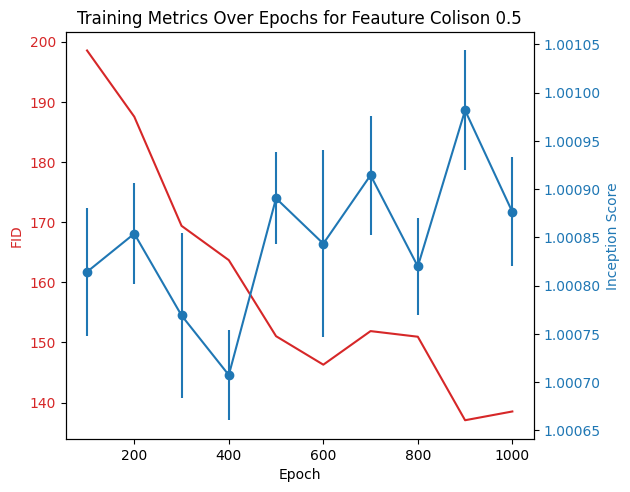

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, applications
from tensorflow.keras.applications.inception_v3 import preprocess_input
import numpy as np
from scipy.linalg import sqrtm
import matplotlib.pyplot as plt
import os

# Load and preprocess the CIFAR-10 dataset
def load_cifar10_data():
    (x_train, _), (_, _) = tf.keras.datasets.cifar10.load_data()
    x_train = (x_train.astype('float32') - 127.5) / 127.5  # Normalize the images to [-1, 1]
    return x_train

x_train = load_cifar10_data()

# Generator model
def make_generator_model():
    model = tf.keras.Sequential([
        layers.Dense(8*8*512, use_bias=False, input_shape=(100,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Reshape((8, 8, 512)),
        layers.Conv2DTranspose(256, (5, 5), strides=(1, 1), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(3, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh')
    ])
    return model

generator = make_generator_model()

# discriminator model
def make_discriminator_model():
    model = tf.keras.Sequential([
        layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Flatten(),
        layers.Dense(1)
    ])
    return model

discriminator = make_discriminator_model()

# loss and optimizers
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)


def apply_feature_collisions(x_train, alpha=0.3):
    # Number of images to blend with each other
    num_images = x_train.shape[0]

    # Create an index for shuffled data
    indices = np.arange(num_images)
    np.random.shuffle(indices)

    # Blend images
    x_train_collided = alpha * x_train + (1 - alpha) * x_train[indices]
    return x_train_collided


# Instantiate the InceptionV3 model here so it's only loaded once
inception_model = applications.InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))


# Calculate FID
def calculate_fid(model, inception_model, real_images, input_noise):
    generated_images = model(input_noise, training=False)
    generated_images = (generated_images + 1) / 2  # Scale from [-1, 1] to [0, 1]

    # Resize images
    real_images_resized = tf.image.resize(real_images, (299, 299))
    generated_images_resized = tf.image.resize(generated_images, (299, 299))

    # Use the provided InceptionV3 model to calculate activations
    real_activations = inception_model.predict(real_images_resized)
    fake_activations = inception_model.predict(generated_images_resized)

    # Calculate mean and covariance in double precision
    mu1 = np.mean(real_activations, axis=0).astype(np.float64)
    mu2 = np.mean(fake_activations, axis=0).astype(np.float64)
    sigma1 = np.cov(real_activations, rowvar=False).astype(np.float64)
    sigma2 = np.cov(fake_activations, rowvar=False).astype(np.float64)

    # Add epsilon to the diagonal of covariance to avoid numerical instability
    eps = 1e-6
    sigma1 += np.eye(sigma1.shape[0]) * eps
    sigma2 += np.eye(sigma2.shape[0]) * eps

    # Calculate FID
    ssdiff = np.sum((mu1 - mu2) ** 2)
    covmean = sqrtm(sigma1.dot(sigma2))

    # Check for imaginary numbers in covmean and handle them
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            raise ValueError('Imaginary component present')
        covmean = covmean.real

    fid = ssdiff + np.trace(sigma1 + sigma2 - 2 * covmean)
    return fid



def inception_score(images, model, num_splits=10):
    # Process images
    images = tf.image.resize(images, (299, 299))  # Resize images to fit InceptionV3 input
    images = preprocess_input(images)  # Preprocess images as required by InceptionV3

    preds = model.predict(images)  # Get model predictions
    scores = []

    for i in range(num_splits):
        part = preds[(preds.shape[0] // num_splits) * i:(preds.shape[0] // num_splits) * (i + 1), :]
        kl_div = part * (np.log(part) - np.log(np.expand_dims(np.mean(part, axis=0), 0)))
        kl_div = np.mean(np.sum(kl_div, axis=1))
        scores.append(np.exp(kl_div))

    # Return mean and std of scores
    return np.mean(scores), np.std(scores)

# Load the full InceptionV3 model with classification head to compute probabilities
inception_model_is = tf.keras.applications.InceptionV3(include_top=True, input_shape=(299, 299, 3), weights='imagenet')

def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False) * 0.5 + 0.5
    predictions = (predictions * 255).numpy().astype(np.uint8)
    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i])
        plt.axis('off')

    os.makedirs('images', exist_ok=True)
    plt.savefig(f'images/image_at_epoch_{epoch:04d}.png')
    plt.close()

@tf.function
def train_step(images, batch_size):
    noise = tf.random.normal([batch_size, 100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

def train(dataset, epochs, save_interval, fid_interval, is_interval):
    fid_scores = []
    is_scores = []
    epochs_recorded = []

    for epoch in range(epochs):
        gen_loss_list = []
        disc_loss_list = []

        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch, batch_size)
            gen_loss_list.append(gen_loss)
            disc_loss_list.append(disc_loss)

        gen_loss_avg = tf.reduce_mean(gen_loss_list)
        disc_loss_avg = tf.reduce_mean(disc_loss_list)
        print(f'Epoch {epoch + 1}/{epochs}, Generator Loss: {gen_loss_avg:.4f}, Discriminator Loss: {disc_loss_avg:.4f}')

        if (epoch + 1) % save_interval == 0:
            print(f'Epoch {epoch + 1}/{epochs}, Generator Loss: {np.mean(gen_loss_list):.4f}, Discriminator Loss: {np.mean(disc_loss_list):.4f}')
            generate_and_save_images(generator, epoch + 1, seed)

        if (epoch + 1) % fid_interval == 0:
            noise = tf.random.normal([1000, 100])  # Generate new noise
            generated_images = generator(noise, training=False)
            fid_value = calculate_fid(generator, inception_model, x_train[:1000], noise)
            fid_scores.append(fid_value)
            epochs_recorded.append(epoch + 1)
            print(f'Epoch {epoch + 1}, FID: {fid_value:.2f}')

        if (epoch + 1) % is_interval == 0:
            noise = tf.random.normal([1000, 100])  # Generate new noise
            generated_images = generator(noise, training=False)
            is_mean, is_std = inception_score(generated_images, inception_model_is)
            is_scores.append((is_mean, is_std))
            print(f'Epoch {epoch + 1}, Inception Score: {is_mean:.2f} ± {is_std:.2f}')

    return epochs_recorded, fid_scores, is_scores


def plot_metrics(epochs, fid_scores, is_scores):
    fig, ax1 = plt.subplots()

    # Plot FID scores
    color = 'tab:red'
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('FID', color=color)
    ax1.plot(epochs, fid_scores, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    # Instantiate a second y-axis for Inception Score
    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('Inception Score', color=color)  # we already handled the x-label with ax1
    is_means = [score[0] for score in is_scores]
    is_stds = [score[1] for score in is_scores]
    ax2.errorbar(epochs, is_means, yerr=is_stds, fmt='-o', color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.title('Training Metrics Over Epochs for Feauture Colison 0.5')
    plt.show()

#configure parameters
batch_size = 256
epochs = 1000
save_interval = 100
fid_interval = 100
is_interval = 100

# Seed for consistent image generation
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, 100])

# Batch and shuffle the data
collision_levels = 0.3  # Adjust this to test different levels of feature collisions
collided_x_train = apply_feature_collisions(x_train, collision_levels)

# Convert to a TensorFlow dataset
train_dataset = tf.data.Dataset.from_tensor_slices(collided_x_train).shuffle(50000).batch(batch_size)

# Collecting metrics
epochs_recorded, fid_scores, is_scores = train(train_dataset, epochs, save_interval, fid_interval, is_interval)
plot_metrics(epochs_recorded, fid_scores, is_scores)


# Feauture Colison 0.5


Epoch 1/1000, Generator Loss: 1.5244, Discriminator Loss: 1.0303
Epoch 2/1000, Generator Loss: 1.0209, Discriminator Loss: 1.1686
Epoch 3/1000, Generator Loss: 1.1698, Discriminator Loss: 1.1471
Epoch 4/1000, Generator Loss: 0.9288, Discriminator Loss: 1.2754
Epoch 5/1000, Generator Loss: 1.0595, Discriminator Loss: 1.1910
Epoch 6/1000, Generator Loss: 1.0901, Discriminator Loss: 1.2022
Epoch 7/1000, Generator Loss: 1.2666, Discriminator Loss: 1.1505
Epoch 8/1000, Generator Loss: 1.1118, Discriminator Loss: 1.2159
Epoch 9/1000, Generator Loss: 1.0210, Discriminator Loss: 1.2409
Epoch 10/1000, Generator Loss: 1.0980, Discriminator Loss: 1.2334
Epoch 11/1000, Generator Loss: 1.0680, Discriminator Loss: 1.2261
Epoch 12/1000, Generator Loss: 1.0387, Discriminator Loss: 1.2431
Epoch 13/1000, Generator Loss: 0.9983, Discriminator Loss: 1.2533
Epoch 14/1000, Generator Loss: 1.0243, Discriminator Loss: 1.2329
Epoch 15/1000, Generator Loss: 0.9547, Discriminator Loss: 1.2569
Epoch 16/1000, Gene

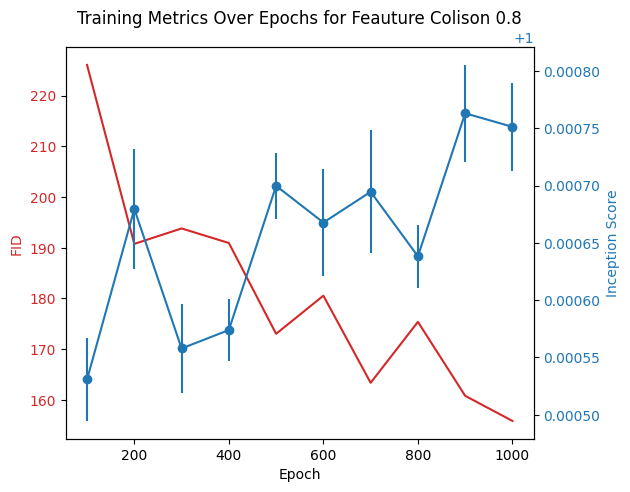

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, applications
from tensorflow.keras.applications.inception_v3 import preprocess_input
import numpy as np
from scipy.linalg import sqrtm
import matplotlib.pyplot as plt
import os

# Load and preprocess the CIFAR-10 dataset
def load_cifar10_data():
    (x_train, _), (_, _) = tf.keras.datasets.cifar10.load_data()
    x_train = (x_train.astype('float32') - 127.5) / 127.5  # Normalize the images to [-1, 1]
    return x_train

x_train = load_cifar10_data()

# generator model
def make_generator_model():
    model = tf.keras.Sequential([
        layers.Dense(8*8*512, use_bias=False, input_shape=(100,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Reshape((8, 8, 512)),
        layers.Conv2DTranspose(256, (5, 5), strides=(1, 1), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(3, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh')
    ])
    return model

generator = make_generator_model()

# discriminator model
def make_discriminator_model():
    model = tf.keras.Sequential([
        layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Flatten(),
        layers.Dense(1)
    ])
    return model

discriminator = make_discriminator_model()

# loss and optimizers
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)


def apply_feature_collisions(x_train, alpha=0.5):
    # Number of images to blend with each other
    num_images = x_train.shape[0]

    # Create an index for shuffled data
    indices = np.arange(num_images)
    np.random.shuffle(indices)

    # Blend images
    x_train_collided = alpha * x_train + (1 - alpha) * x_train[indices]
    return x_train_collided


# Instantiate the InceptionV3 model here so it's only loaded once
inception_model = applications.InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))


# Calculate FID
def calculate_fid(model, inception_model, real_images, input_noise):
    generated_images = model(input_noise, training=False)
    generated_images = (generated_images + 1) / 2  # Scale from [-1, 1] to [0, 1]

    # Resize images
    real_images_resized = tf.image.resize(real_images, (299, 299))
    generated_images_resized = tf.image.resize(generated_images, (299, 299))

    # Use the provided InceptionV3 model to calculate activations
    real_activations = inception_model.predict(real_images_resized)
    fake_activations = inception_model.predict(generated_images_resized)

    # Calculate mean and covariance in double precision
    mu1 = np.mean(real_activations, axis=0).astype(np.float64)
    mu2 = np.mean(fake_activations, axis=0).astype(np.float64)
    sigma1 = np.cov(real_activations, rowvar=False).astype(np.float64)
    sigma2 = np.cov(fake_activations, rowvar=False).astype(np.float64)

    # Add epsilon to the diagonal of covariance to avoid numerical instability
    eps = 1e-6
    sigma1 += np.eye(sigma1.shape[0]) * eps
    sigma2 += np.eye(sigma2.shape[0]) * eps

    # Calculate FID
    ssdiff = np.sum((mu1 - mu2) ** 2)
    covmean = sqrtm(sigma1.dot(sigma2))

    # Check for imaginary numbers in covmean and handle them
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            raise ValueError('Imaginary component present')
        covmean = covmean.real

    fid = ssdiff + np.trace(sigma1 + sigma2 - 2 * covmean)
    return fid



def inception_score(images, model, num_splits=10):
    # Process images
    images = tf.image.resize(images, (299, 299))  # Resize images to fit InceptionV3 input
    images = preprocess_input(images)  # Preprocess images as required by InceptionV3

    preds = model.predict(images)  # Get model predictions
    scores = []

    for i in range(num_splits):
        part = preds[(preds.shape[0] // num_splits) * i:(preds.shape[0] // num_splits) * (i + 1), :]
        kl_div = part * (np.log(part) - np.log(np.expand_dims(np.mean(part, axis=0), 0)))
        kl_div = np.mean(np.sum(kl_div, axis=1))
        scores.append(np.exp(kl_div))

    # Return mean and std of scores
    return np.mean(scores), np.std(scores)

# Load the full InceptionV3 model with classification head to compute probabilities
inception_model_is = tf.keras.applications.InceptionV3(include_top=True, input_shape=(299, 299, 3), weights='imagenet')

def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False) * 0.5 + 0.5
    predictions = (predictions * 255).numpy().astype(np.uint8)
    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i])
        plt.axis('off')

    os.makedirs('images', exist_ok=True)
    plt.savefig(f'images/image_at_epoch_{epoch:04d}.png')
    plt.close()

@tf.function
def train_step(images, batch_size):
    noise = tf.random.normal([batch_size, 100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

def train(dataset, epochs, save_interval, fid_interval, is_interval):
    fid_scores = []
    is_scores = []
    epochs_recorded = []

    for epoch in range(epochs):
        gen_loss_list = []
        disc_loss_list = []

        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch, batch_size)
            gen_loss_list.append(gen_loss)
            disc_loss_list.append(disc_loss)

        gen_loss_avg = tf.reduce_mean(gen_loss_list)
        disc_loss_avg = tf.reduce_mean(disc_loss_list)
        print(f'Epoch {epoch + 1}/{epochs}, Generator Loss: {gen_loss_avg:.4f}, Discriminator Loss: {disc_loss_avg:.4f}')

        if (epoch + 1) % save_interval == 0:
            print(f'Epoch {epoch + 1}/{epochs}, Generator Loss: {np.mean(gen_loss_list):.4f}, Discriminator Loss: {np.mean(disc_loss_list):.4f}')
            generate_and_save_images(generator, epoch + 1, seed)

        if (epoch + 1) % fid_interval == 0:
            noise = tf.random.normal([1000, 100])  # Generate new noise
            generated_images = generator(noise, training=False)
            fid_value = calculate_fid(generator, inception_model, x_train[:1000], noise)
            fid_scores.append(fid_value)
            epochs_recorded.append(epoch + 1)
            print(f'Epoch {epoch + 1}, FID: {fid_value:.2f}')

        if (epoch + 1) % is_interval == 0:
            noise = tf.random.normal([1000, 100])  # Generate new noise
            generated_images = generator(noise, training=False)
            is_mean, is_std = inception_score(generated_images, inception_model_is)
            is_scores.append((is_mean, is_std))
            print(f'Epoch {epoch + 1}, Inception Score: {is_mean:.2f} ± {is_std:.2f}')

    return epochs_recorded, fid_scores, is_scores


def plot_metrics(epochs, fid_scores, is_scores):
    fig, ax1 = plt.subplots()

    # Plot FID scores
    color = 'tab:red'
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('FID', color=color)
    ax1.plot(epochs, fid_scores, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    # Instantiate a second y-axis for Inception Score
    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('Inception Score', color=color)  # we already handled the x-label with ax1
    is_means = [score[0] for score in is_scores]
    is_stds = [score[1] for score in is_scores]
    ax2.errorbar(epochs, is_means, yerr=is_stds, fmt='-o', color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.title('Training Metrics Over Epochs for Feauture Colison 0.8')
    plt.show()

#configure parameters
batch_size = 256
epochs = 1000
save_interval = 100
fid_interval = 100
is_interval = 100

# Seed for consistent image generation
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, 100])

# Batch and shuffle the data
collision_levels = 0.5  # Adjust this to test different levels of feature collisions
collided_x_train = apply_feature_collisions(x_train, collision_levels)

# Convert to a TensorFlow dataset
train_dataset = tf.data.Dataset.from_tensor_slices(collided_x_train).shuffle(50000).batch(batch_size)

# Collecting metrics
epochs_recorded, fid_scores, is_scores = train(train_dataset, epochs, save_interval, fid_interval, is_interval)
plot_metrics(epochs_recorded, fid_scores, is_scores)


# Feauture Colison 0.8


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, applications
from tensorflow.keras.applications.inception_v3 import preprocess_input
import numpy as np
from scipy.linalg import sqrtm
import matplotlib.pyplot as plt
import os

# Load and preprocess the CIFAR-10 dataset
def load_cifar10_data():
    (x_train, _), (_, _) = tf.keras.datasets.cifar10.load_data()
    x_train = (x_train.astype('float32') - 127.5) / 127.5  # Normalize the images to [-1, 1]
    return x_train

x_train = load_cifar10_data()

# generator model
def make_generator_model():
    model = tf.keras.Sequential([
        layers.Dense(8*8*512, use_bias=False, input_shape=(100,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Reshape((8, 8, 512)),
        layers.Conv2DTranspose(256, (5, 5), strides=(1, 1), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(3, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh')
    ])
    return model

generator = make_generator_model()

# discriminator model
def make_discriminator_model():
    model = tf.keras.Sequential([
        layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Flatten(),
        layers.Dense(1)
    ])
    return model

discriminator = make_discriminator_model()

#loss and optimizers
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)


def apply_feature_collisions(x_train, alpha=0.5):
    # Number of images to blend with each other
    num_images = x_train.shape[0]

    # Create an index for shuffled data
    indices = np.arange(num_images)
    np.random.shuffle(indices)

    # Blend images
    x_train_collided = alpha * x_train + (1 - alpha) * x_train[indices]
    return x_train_collided


# Instantiate the InceptionV3 model here so it's only loaded once
inception_model = applications.InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))


# Calculate FID
def calculate_fid(model, inception_model, real_images, input_noise):
    generated_images = model(input_noise, training=False)
    generated_images = (generated_images + 1) / 2  # Scale from [-1, 1] to [0, 1]

    # Resize images
    real_images_resized = tf.image.resize(real_images, (299, 299))
    generated_images_resized = tf.image.resize(generated_images, (299, 299))

    # Use the provided InceptionV3 model to calculate activations
    real_activations = inception_model.predict(real_images_resized)
    fake_activations = inception_model.predict(generated_images_resized)

    # Calculate mean and covariance in double precision
    mu1 = np.mean(real_activations, axis=0).astype(np.float64)
    mu2 = np.mean(fake_activations, axis=0).astype(np.float64)
    sigma1 = np.cov(real_activations, rowvar=False).astype(np.float64)
    sigma2 = np.cov(fake_activations, rowvar=False).astype(np.float64)

    # Add epsilon to the diagonal of covariance to avoid numerical instability
    eps = 1e-6
    sigma1 += np.eye(sigma1.shape[0]) * eps
    sigma2 += np.eye(sigma2.shape[0]) * eps

    # Calculate FID
    ssdiff = np.sum((mu1 - mu2) ** 2)
    covmean = sqrtm(sigma1.dot(sigma2))

    # Check for imaginary numbers in covmean and handle them
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            raise ValueError('Imaginary component present')
        covmean = covmean.real

    fid = ssdiff + np.trace(sigma1 + sigma2 - 2 * covmean)
    return fid



def inception_score(images, model, num_splits=10):
    # Process images
    images = tf.image.resize(images, (299, 299))  # Resize images to fit InceptionV3 input
    images = preprocess_input(images)  # Preprocess images as required by InceptionV3

    preds = model.predict(images)  # Get model predictions
    scores = []

    for i in range(num_splits):
        part = preds[(preds.shape[0] // num_splits) * i:(preds.shape[0] // num_splits) * (i + 1), :]
        kl_div = part * (np.log(part) - np.log(np.expand_dims(np.mean(part, axis=0), 0)))
        kl_div = np.mean(np.sum(kl_div, axis=1))
        scores.append(np.exp(kl_div))

    # Return mean and std of scores
    return np.mean(scores), np.std(scores)

# Load the full InceptionV3 model with classification head to compute probabilities
inception_model_is = tf.keras.applications.InceptionV3(include_top=True, input_shape=(299, 299, 3), weights='imagenet')

def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False) * 0.5 + 0.5
    predictions = (predictions * 255).numpy().astype(np.uint8)
    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i])
        plt.axis('off')

    os.makedirs('images', exist_ok=True)
    plt.savefig(f'images/image_at_epoch_{epoch:04d}.png')
    plt.close()

@tf.function
def train_step(images, batch_size):
    noise = tf.random.normal([batch_size, 100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

def train(dataset, epochs, save_interval, fid_interval, is_interval):
    fid_scores = []
    is_scores = []
    epochs_recorded = []

    for epoch in range(epochs):
        gen_loss_list = []
        disc_loss_list = []

        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch, batch_size)
            gen_loss_list.append(gen_loss)
            disc_loss_list.append(disc_loss)

        gen_loss_avg = tf.reduce_mean(gen_loss_list)
        disc_loss_avg = tf.reduce_mean(disc_loss_list)
        print(f'Epoch {epoch + 1}/{epochs}, Generator Loss: {gen_loss_avg:.4f}, Discriminator Loss: {disc_loss_avg:.4f}')

        if (epoch + 1) % save_interval == 0:
            print(f'Epoch {epoch + 1}/{epochs}, Generator Loss: {np.mean(gen_loss_list):.4f}, Discriminator Loss: {np.mean(disc_loss_list):.4f}')
            generate_and_save_images(generator, epoch + 1, seed)

        if (epoch + 1) % fid_interval == 0:
            noise = tf.random.normal([1000, 100])  # Generate new noise
            generated_images = generator(noise, training=False)
            fid_value = calculate_fid(generator, inception_model, x_train[:1000], noise)
            fid_scores.append(fid_value)
            epochs_recorded.append(epoch + 1)
            print(f'Epoch {epoch + 1}, FID: {fid_value:.2f}')

        if (epoch + 1) % is_interval == 0:
            noise = tf.random.normal([1000, 100])  # Generate new noise
            generated_images = generator(noise, training=False)
            is_mean, is_std = inception_score(generated_images, inception_model_is)
            is_scores.append((is_mean, is_std))
            print(f'Epoch {epoch + 1}, Inception Score: {is_mean:.2f} ± {is_std:.2f}')

    return epochs_recorded, fid_scores, is_scores


def plot_metrics(epochs, fid_scores, is_scores):
    fig, ax1 = plt.subplots()

    # Plot FID scores
    color = 'tab:red'
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('FID', color=color)
    ax1.plot(epochs, fid_scores, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    # Instantiate a second y-axis for Inception Score
    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('Inception Score', color=color)  # we already handled the x-label with ax1
    is_means = [score[0] for score in is_scores]
    is_stds = [score[1] for score in is_scores]
    ax2.errorbar(epochs, is_means, yerr=is_stds, fmt='-o', color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.title('Training Metrics Over Epochs for Feauture Colison 0.8')
    plt.show()

#configure parameters
batch_size = 256
epochs = 1000
save_interval = 100
fid_interval = 100
is_interval = 100

# Seed for consistent image generation
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, 100])

# Batch and shuffle the data
collision_levels = 0.5  # Adjust this to test different levels of feature collisions
collided_x_train = apply_feature_collisions(x_train, collision_levels)

# Convert to a TensorFlow dataset
train_dataset = tf.data.Dataset.from_tensor_slices(collided_x_train).shuffle(50000).batch(batch_size)

# Collecting metrics
epochs_recorded, fid_scores, is_scores = train(train_dataset, epochs, save_interval, fid_interval, is_interval)
plot_metrics(epochs_recorded, fid_scores, is_scores)
